## Bayesian Neural Network

This notebook illustrates a practical implementation of a Bayesian Neural Network (BNN) with [TensorFlow Probability](https://www.tensorflow.org/probability) 

Import required libraries

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras as keras
import numpy as np
import matplotlib.pyplot as plt

2024-09-04 23:48:02.265173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 23:48:02.285857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 23:48:02.292253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 23:48:02.307536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 23:48:03.693526: W tensorflow/compiler/tf2

In [2]:
# Initialize imported modules
tfd = tfp.distributions
tfpl = tfp.layers

Create dataset

In [3]:
# Generate some data
np.random.seed(42)
X = np.linspace(-1, 1, 100)[:, np.newaxis]
Y = X**3 + 0.1 * np.random.normal(size=X.shape)

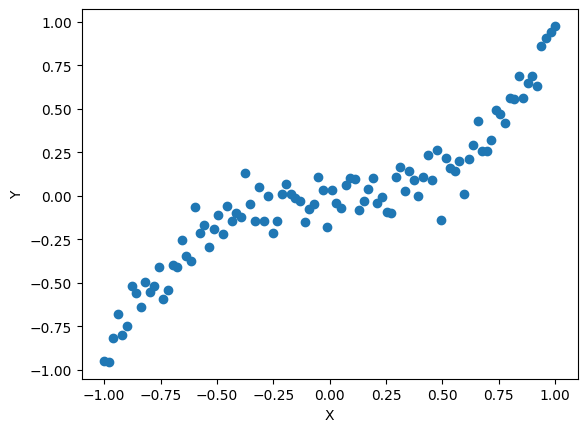

In [4]:
# Visualize the data
plt.scatter(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [13]:
# Define the model
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def bnn_model():
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(1,)),
        tfpl.DenseVariational(
            units=10, 
            make_posterior_fn=posterior, 
            make_prior_fn=prior,
            kl_weight=1/X.shape[0], # KL divergence weight
        ),
        keras.layers.Activation('relu'),
        tfpl.DenseVariational(
            units=10, 
            make_posterior_fn=posterior, 
            make_prior_fn=prior,
            kl_weight=1/X.shape[0], # KL divergence weight
        ),
        keras.layers.Activation('sigmoid'),
        keras.layers.Dense(1)
    ])
    return model

In [14]:
# Compile the model
model = bnn_model()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01), loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])

In [15]:
model.fit(X, Y, epochs=100)

Epoch 1/100
4/4 [==============================] - 2s 8ms/step - loss: 1.6949 - root_mean_squared_error: 1.2192
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6673 - root_mean_squared_error: 0.6629
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.5609 - root_mean_squared_error: 0.6373
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2373 - root_mean_squared_error: 1.0213
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6521 - root_mean_squared_error: 0.7190
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.8199 - root_mean_squared_error: 0.8328
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.7044 - root_mean_squared_error: 0.6984
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.4226 - root_mean_squared_error: 0.4670
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3607 - root_mean_squared_error:

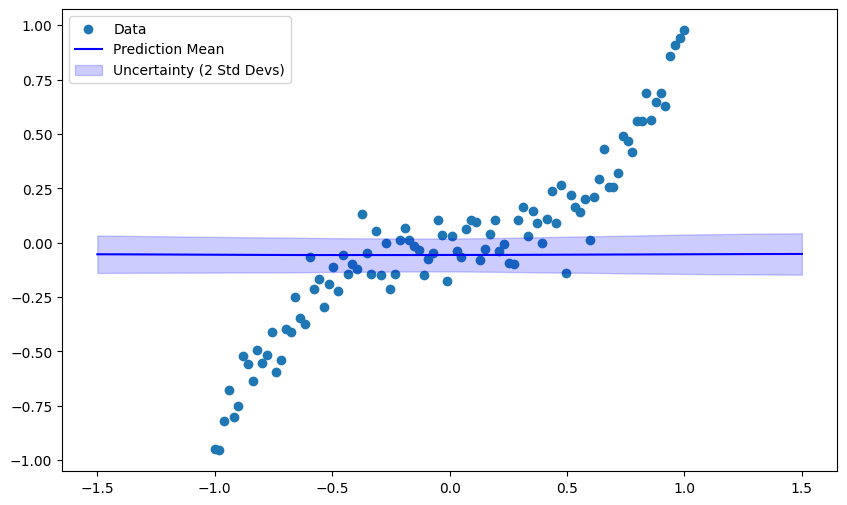

In [17]:
# Function to make predictions and estimate uncertainty
def predict_bnn(model, X_test, num_samples=100):
    preds = np.array([model(X_test) for _ in range(num_samples)])
    pred_mean = preds.mean(axis=0)
    pred_std = preds.std(axis=0)
    return pred_mean, pred_std

# Test data
X_test = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
pred_mean, pred_std = predict_bnn(model, X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Data')
plt.plot(X_test, pred_mean, color='blue', label='Prediction Mean')
plt.fill_between(X_test.flatten(),
                 (pred_mean - 2 * pred_std).flatten(),
                 (pred_mean + 2 * pred_std).flatten(),
                 color='blue', alpha=0.2, label='Uncertainty (2 Std Devs)')
plt.legend()
plt.show()